# Stroke Detection
### Justin Farnsworth (farnswj1@tcnj.edu)

In [1]:
# Make pyspark importable
import findspark
findspark.init()

In [2]:
# Imported libraries
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import col, explode, array, lit

In [3]:
# Set up the Spark session
spark = SparkSession.builder.appName("Stroke Detection").getOrCreate()

In [4]:
# Load the dataset
df = spark.read.csv("healthcare-dataset-stroke-data.csv", inferSchema=True, header=True)
df_pandas = df.toPandas()
df_pandas.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,N/A,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24,never smoked,1


In [5]:
# Show the schema
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [6]:
# Remove the ID column
df = df.drop("id")
df_pandas = df.toPandas()
df_pandas

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,N/A,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,N/A,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [7]:
# Remove rows with an undefined BMI
df = df.filter(df["bmi"] != "N/A")

In [8]:
# Convert BMI from string to float
df = df.withColumn("bmi", col("bmi").cast("double"))
df_pandas = df.toPandas()
df_pandas

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
4904,Female,13.0,0,0,No,children,Rural,103.08,18.6,Unknown,0
4905,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
4906,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
4907,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [9]:
# Check for null values
df_pandas.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [10]:
# Show summary statistics on the numerical data
df_pandas.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000
mean,42.865374,0.091872,0.049501,105.305150,28.893237,0.042575
std,22.555115,0.288875,0.216934,44.424341,7.854067,0.201917
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.070000,23.500000,0.000000
50%,44.000000,0.000000,0.000000,91.680000,28.100000,0.000000
75%,60.000000,0.000000,0.000000,113.570000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [11]:
# Identify categories in the gender column
df_pandas["gender"].value_counts()

Female    2897
Male      2011
Other        1
Name: gender, dtype: int64

In [12]:
# Drop the row with the gender containing "Other" since there is insufficent data with this value
df = df.filter(df["gender"] != "Other")
df_pandas = df.toPandas()
df.show(5)

+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
|Female|79.0|           1|            0|         Yes|Self-employed|         Rural|           174.12|24.0|   never smoked|     1|
|  Male|81.0|           0|            0|         Yes|      Private|         Urban|           186.

In [13]:
# Identify categories in the ever_married column
df_pandas["ever_married"].value_counts()

Yes    3204
No     1704
Name: ever_married, dtype: int64

In [14]:
# Identify the types of work in the dataset
df_pandas["work_type"].value_counts()

Private          2810
Self-employed     775
children          671
Govt_job          630
Never_worked       22
Name: work_type, dtype: int64

In [15]:
# Identify the different residence types
df_pandas["Residence_type"].value_counts()

Urban    2490
Rural    2418
Name: Residence_type, dtype: int64

In [16]:
# Identify the different categories under smoking status
df_pandas["smoking_status"].value_counts()

never smoked       1852
Unknown            1483
formerly smoked     836
smokes              737
Name: smoking_status, dtype: int64

In [17]:
# Count the total number of strokes cases vs. non-stroke cases
df_pandas["stroke"].value_counts()

0    4699
1     209
Name: stroke, dtype: int64

In [18]:
# Oversample the data
major_df = df.filter(col("stroke") == 0)
minor_df = df.filter(col("stroke") == 1)
ratio = int(major_df.count()/minor_df.count())

# Duplicate the minority rows
temp_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in range(ratio)]))).drop("dummy")

# Merge the oversampled minority data with the majority rows
oversampled_df = major_df.unionAll(temp_df)
oversampled_df

DataFrame[gender: string, age: double, hypertension: int, heart_disease: int, ever_married: string, work_type: string, Residence_type: string, avg_glucose_level: double, bmi: double, smoking_status: string, stroke: int]

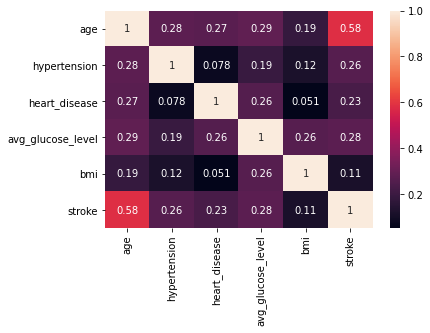

In [19]:
# Plot the heatmap of the numerical data
sns.heatmap(oversampled_df.toPandas().corr(), annot=True)
plt.show()

In [20]:
# Split the data into a training set and a test set
train_set, test_set = oversampled_df.randomSplit([0.7, 0.3], 3)

In [21]:
# Set up the string indexers
gender_indexer = StringIndexer(inputCol="gender", outputCol="gender_index")
married_indexer = StringIndexer(inputCol="ever_married", outputCol="ever_married_index")
residence_indexer = StringIndexer(inputCol="Residence_type", outputCol="Residence_type_index")
work_indexer = StringIndexer(inputCol="work_type", outputCol="work_type_index")
smoking_indexer = StringIndexer(inputCol="smoking_status", outputCol="smoking_status_index")

In [22]:
# Set up the one-hot encoders
work_encoder = OneHotEncoder(inputCol="work_type_index", outputCol="work_type_vec")
smoking_encoder = OneHotEncoder(inputCol="smoking_status_index", outputCol="smoking_status_vec")

In [23]:
# Set up the assembler
features = [
    "gender_index", "age", "hypertension", "heart_disease", 
    "ever_married_index", "work_type_vec", "Residence_type_index", 
    "avg_glucose_level", "bmi", "smoking_status_vec"
]
assembler = VectorAssembler(inputCols=features, outputCol="features")

In [24]:
# Use logistic regression
rf = RandomForestClassifier(featuresCol="features", labelCol="stroke")

In [25]:
# Make a param grid
grid = ParamGridBuilder()\
       .addGrid(rf.maxDepth, [5, 10, 15])\
       .addGrid(rf.maxBins, [5, 10, 15, 20])\
       .addGrid(rf.numTrees, [10, 30, 50])\
       .build()

In [26]:
# Use the evaluator to measure the performance of the model
evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="accuracy")

In [27]:
# Set up cross-validation
cv = CrossValidator(estimator=rf, estimatorParamMaps=grid, evaluator=evaluator, numFolds=5)

In [28]:
# Set up the pipeline
pipeline = Pipeline(
    stages=[gender_indexer, married_indexer, residence_indexer, work_indexer, 
            smoking_indexer, work_encoder, smoking_encoder, assembler, cv]
)

In [29]:
# Fit the model
model = pipeline.fit(train_set)

In [30]:
# Make the predictions
predictions = model.transform(test_set).select(col("stroke").cast("double"), col("prediction"))
predictions.show()

+------+----------+
|stroke|prediction|
+------+----------+
|   0.0|       0.0|
|   0.0|       0.0|
|   0.0|       0.0|
|   0.0|       0.0|
|   0.0|       0.0|
|   0.0|       0.0|
|   0.0|       0.0|
|   0.0|       0.0|
|   0.0|       0.0|
|   0.0|       0.0|
|   0.0|       0.0|
|   0.0|       0.0|
|   0.0|       0.0|
|   0.0|       0.0|
|   0.0|       0.0|
|   0.0|       0.0|
|   0.0|       0.0|
|   0.0|       0.0|
|   0.0|       0.0|
|   0.0|       0.0|
+------+----------+
only showing top 20 rows



In [31]:
# Determine the accuracy
evaluator.evaluate(predictions)

0.9783303730017762

In [32]:
# Show the confusion matrix
metrics = MulticlassMetrics(predictions.rdd)
metrics.confusionMatrix().toArray()

array([[1367.,    0.],
       [  61., 1387.]])

In [33]:
# Terminate the Spark session
spark.stop()